In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
data_path = "C:/Users/maffd/Desktop/CS412/dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:10<00:00, 12.11it/s]


In [3]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [4]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [5]:
answers = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    chat_gpt_answers = []
    for conv in convos:
        if conv["role"] == "assistant":
            answers.append(conv["text"])
            chat_gpt_answers.append(conv["text"])
    code2prompts[code] = chat_gpt_answers    

In [6]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [7]:
answers[0]

"You can load a CSV file into a Pandas DataFrame in Python using the pandas.read_csv() function. Here's how you can do it for your specific CSV file:pythonCopy codeimport pandas as pd\n\n# Specify the file path\nfile_path = 'cs412_hw1_dataset.csv'\n\n# Load the CSV file into a Pandas DataFrame\ndf = pd.read_csv(file_path)\n\n# Display the first few rows of the DataFrame to verify the data has been loaded\nprint(df.head())\nThis code assumes that the CSV file 'cs412_hw1_dataset.csv' is in the same directory as your Python script or Jupyter Notebook. If the file is in a different directory, you can specify the full path to the file in the file_path variable.The pd.read_csv() function will automatically infer the column names from the first row of the CSV file, so you don't need to explicitly specify the column names unless they are different from what you provided. You can access columns in the DataFrame using their names, e.g., df['Species'], df['Island'], etc."

In [8]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [9]:
# TF-IDF Approach

vectorizer_tf_idf = TfidfVectorizer()
vectorizer_tf_idf = vectorizer_tf_idf.fit(prompts + questions + answers)

In [10]:
# Bag of Words Approach

from sklearn.feature_extraction.text import CountVectorizer
vectorizer_BoW = CountVectorizer()
vectorizer_BoW = vectorizer_BoW.fit(prompts + questions + answers)

In [11]:
# Word2Vec Approach
from gensim.models import Word2Vec
questions_and_prompts_and_answers = [sentence.split() for sentence in prompts + questions + answers]

vector_size = 500
window = 5
min_count = 5

w2v_model = Word2Vec(
    questions_and_prompts_and_answers,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=4)


def vectorize(q_and_p_and_a, model):
    word_vectors = [model.wv[word] for word in q_and_p_and_a if word in model.wv]

    if not word_vectors:
        return np.zeros(model.vector_size)  # Return zero vector if no word vectors are found

    avg_vector = np.mean(word_vectors, axis=0)
    return avg_vector




In [12]:
# TF-IDF Approach

questions_TF_IDF = pd.DataFrame(vectorizer_tf_idf.transform(questions).toarray(), columns=vectorizer_tf_idf.get_feature_names_out())
questions_TF_IDF.head()

,00,000,00000,000000,000196,000282,000284,000284among,000360,000469,...,ã¼nã¼,ã¼nã¼yorum,ã¼reme,ã¼tlerini,ã¼zerinde,ã¼zerindeki,ã¼zerinden,ã¼ã,ã¼ä,î¼
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Bag of Words Approach

questions_BoW = pd.DataFrame(vectorizer_BoW.transform(questions).toarray(), columns=vectorizer_BoW.get_feature_names_out())
questions_BoW.head()

,00,000,00000,000000,000196,000282,000284,000284among,000360,000469,...,ã¼nã¼,ã¼nã¼yorum,ã¼reme,ã¼tlerini,ã¼zerinde,ã¼zerindeki,ã¼zerinden,ã¼ã,ã¼ä,î¼
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Word2Vec Approach

questions_Word2Vec = pd.DataFrame([vectorize(sentence, w2v_model) for sentence in questions], columns=[f'w2v_{i}' for i in range(vector_size)])
questions_Word2Vec.head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_490,w2v_491,w2v_492,w2v_493,w2v_494,w2v_495,w2v_496,w2v_497,w2v_498,w2v_499
0,0.071626,0.118880,0.059357,0.075288,-0.010679,-0.179663,0.003208,0.007354,-0.204849,0.047947,...,-0.059396,-0.009517,0.015871,-0.133413,-0.198162,0.143136,-0.156960,-0.198732,-0.073524,0.150904
1,0.134874,0.192276,0.097063,0.167254,0.032993,-0.263814,-0.102384,0.019913,-0.378226,0.152578,...,-0.087351,0.013377,-0.003798,-0.254214,-0.303550,0.252436,-0.225254,-0.303082,-0.026571,0.249545
2,0.111200,0.083777,0.060572,0.166192,0.021036,-0.178306,-0.004097,0.076232,-0.256636,0.068522,...,-0.125817,0.014733,0.082643,-0.132120,-0.143168,0.069867,-0.169532,-0.142302,-0.035185,0.063486
3,0.089705,0.111213,0.126548,0.070874,-0.055204,-0.202195,0.013267,0.061339,-0.231134,-0.027752,...,-0.061286,-0.016094,0.073534,-0.137557,-0.192375,0.057310,-0.163342,-0.227298,-0.137994,0.119013
4,0.089488,0.142823,0.060096,0.130064,0.003695,-0.218613,-0.015113,0.031324,-0.265156,0.091366,...,-0.077315,0.009208,0.028737,-0.150021,-0.193456,0.168339,-0.184831,-0.215884,-0.069544,0.169461


In [15]:
# TF-IDF Approach

code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    # code = "0031c86e-81f4-4eef-9e0e-28037abf9883", user_prompts = [prompt1, prompt2, ...]
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer_tf_idf.transform(user_prompts).toarray(), columns=vectorizer_tf_idf.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [16]:
# TF-IDF Approach

code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00,000,00000,000000,000196,000282,000284,000284among,000360,000469,...,ã¼nã¼,ã¼nã¼yorum,ã¼reme,ã¼tlerini,ã¼zerinde,ã¼zerindeki,ã¼zerinden,ã¼ã,ã¼ä,î¼
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# TF-IDF Approach

code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 12055)

In [18]:
# Bag of Words Approach

code2prompts_BoW = dict()
for code, user_prompts in code2prompts.items():
    # code = "0031c86e-81f4-4eef-9e0e-28037abf9883", user_prompts = [prompt1, prompt2, ...]
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_BoW = pd.DataFrame(vectorizer_BoW.transform(user_prompts).toarray(), columns=vectorizer_BoW.get_feature_names_out())
    code2prompts_BoW[code] = prompts_BoW

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [19]:
# Bag of Words Approach

code2prompts_BoW["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00,000,00000,000000,000196,000282,000284,000284among,000360,000469,...,ã¼nã¼,ã¼nã¼yorum,ã¼reme,ã¼tlerini,ã¼zerinde,ã¼zerindeki,ã¼zerinden,ã¼ã,ã¼ä,î¼
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Bag of Words Approach

code2prompts_BoW["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 12055)

In [21]:
# Word2Vec Approach

code2prompts_w2v = dict()

for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue

    prompts_Word2Vec = pd.DataFrame([vectorize(sentence.split(), w2v_model) for sentence in user_prompts], columns=[f'w2v_{i}' for i in range(vector_size)])
    code2prompts_w2v[code] = prompts_Word2Vec

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [22]:
# Word2Vec Approach

code2prompts_w2v["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_490,w2v_491,w2v_492,w2v_493,w2v_494,w2v_495,w2v_496,w2v_497,w2v_498,w2v_499
0,0.274505,-0.165889,-0.179778,-0.199957,0.202331,-0.105957,-0.653487,-0.154042,0.046360,0.168550,...,0.570087,-0.335539,-0.200671,-0.328200,-0.170178,0.112554,0.198938,-0.154003,0.241892,-0.058998
1,0.122359,0.048265,-0.114037,-0.000539,0.153021,0.012413,-0.500864,-0.265386,-0.076031,0.120629,...,0.234996,-0.227077,-0.249253,-0.177330,-0.389689,0.323487,0.230434,-0.352376,0.203352,-0.084441
2,-0.081582,-0.017444,0.109380,-0.223902,0.119253,0.198561,-0.306275,-0.262531,-0.100564,0.127423,...,0.161780,-0.086560,-0.334851,-0.219938,-0.260292,0.062957,0.294315,-0.385323,0.198945,-0.195290
3,0.018061,0.142249,-0.132185,0.003426,0.275440,0.068878,-0.285994,-0.125747,-0.111851,0.288108,...,0.278667,0.020851,-0.175601,-0.357369,-0.315539,0.172824,0.057935,-0.446396,-0.018970,-0.280200
4,0.038432,0.132882,-0.097185,0.067883,0.291052,0.057956,-0.296598,-0.134124,-0.095387,0.270736,...,0.239510,-0.017241,-0.218440,-0.275579,-0.279037,0.266435,0.076330,-0.434713,0.001182,-0.217366


In [23]:
# Word2Vec Approach

code2prompts_w2v["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 500)

In [24]:
# TF-IDF Approach

code2cosine_tf_idf = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine_tf_idf[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [25]:
# Bag of Words Approach

code2cosine_BoW = dict()
for code, user_prompts_BoW in code2prompts_BoW.items():
    code2cosine_BoW[code] = pd.DataFrame(cosine_similarity(questions_BoW,user_prompts_BoW))

In [26]:
# Word2Vec Approach

code2cosine_w2v = dict()

for code, user_prompts_w2v in code2prompts_w2v.items():
    cosine_similarity_matrix = cosine_similarity(questions_Word2Vec, user_prompts_w2v)
    code2cosine_w2v[code] = pd.DataFrame(cosine_similarity_matrix)


In [27]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [28]:
# TF-IDF Approach

code2questionmapping_tf_idf = dict()
for code, cosine_scores in code2cosine_tf_idf.items():
    code2questionmapping_tf_idf[code] = code2cosine_tf_idf[code].max(axis=1).tolist()


question_mapping_scores_tf_idf = pd.DataFrame(code2questionmapping_tf_idf).T
question_mapping_scores_tf_idf.reset_index(inplace=True)
question_mapping_scores_tf_idf.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_tf_idf.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores_tf_idf

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.304749,0.429209,0.445114,0.345680,0.407512,0.373424,0.197718,0.167528,0.135585
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.202965,0.363552,0.458672,0.404428,0.365454,0.340874,0.390960,0.316486,0.195958
2,041f950b-c013-409a-a642-cffff60b9d4b,0.164778,0.124030,0.272360,0.264555,0.367945,0.160102,0.204623,0.326275,0.209939
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.176261,0.113966,0.286171,0.486557,0.283867,0.312700,0.344656,0.286588,0.328314
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.297222,0.459364,0.514944,0.395843,0.377086,0.345690,0.343304,0.276648,0.218038
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.194116,0.138503,0.294750,0.264827,0.233940,0.473224,0.480595,0.452540,0.306604
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.181892,0.120247,0.299982,0.423959,0.438067,0.276643,0.269781,0.358475,0.405156
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.255620,0.549038,0.310167,0.403752,0.501302,0.311267,0.483569,0.469128,0.283811
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.359659,0.495860,0.495845,0.514688,0.475517,0.270221,0.439546,0.536880,0.269153


In [29]:
# Bag of Words Approach

code2questionmapping_BoW = dict()
for code, cosine_scores in code2cosine_tf_idf.items():
    code2questionmapping_BoW[code] = code2cosine_BoW[code].max(axis=1).tolist()


question_mapping_scores_BoW = pd.DataFrame(code2questionmapping_BoW).T
question_mapping_scores_BoW.reset_index(inplace=True)
question_mapping_scores_BoW.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_BoW.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores_BoW

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.619439,0.564218,0.705126,0.552229,0.659997,0.589307,0.502981,0.554046,0.414642
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.594736,0.487180,0.736255,0.605228,0.591974,0.588859,0.630582,0.661897,0.520978
2,041f950b-c013-409a-a642-cffff60b9d4b,0.536862,0.390286,0.543560,0.488405,0.536550,0.409906,0.462096,0.588057,0.489059
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.581038,0.442235,0.639362,0.711006,0.542010,0.528981,0.623511,0.628681,0.585251
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.623454,0.507757,0.735626,0.555692,0.649769,0.597020,0.582538,0.617163,0.479929
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.606261,0.470562,0.673534,0.519887,0.491217,0.679408,0.702600,0.752361,0.585670
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.601883,0.423925,0.636372,0.614421,0.663112,0.529308,0.613087,0.629274,0.643909
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.563105,0.700885,0.620076,0.602832,0.726652,0.562719,0.690014,0.744812,0.543800
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.616686,0.568683,0.773015,0.691651,0.705586,0.563098,0.721091,0.782969,0.541163


In [30]:
# Word2Vec Approach

code2questionmapping_w2v = dict()

for code, cosine_scores in code2cosine_w2v.items():
    code2questionmapping_w2v[code] = code2cosine_w2v[code].max(axis=1).tolist()

question_mapping_scores_w2v = pd.DataFrame(code2questionmapping_w2v).T
question_mapping_scores_w2v.reset_index(inplace=True)
question_mapping_scores_w2v.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_w2v.rename(columns={"index": "code"}, inplace=True)

question_mapping_scores_w2v

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.569898,0.559358,0.498455,0.596269,0.529698,0.569420,0.531863,0.500704,0.348046
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.554213,0.553771,0.607182,0.533035,0.520501,0.528132,0.625979,0.501554,0.350057
2,041f950b-c013-409a-a642-cffff60b9d4b,0.622121,0.590521,0.634738,0.603706,0.602858,0.614092,0.645924,0.567128,0.538799
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.567102,0.555681,0.522284,0.543931,0.540727,0.547088,0.533458,0.460165,0.409453
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.618506,0.633889,0.636678,0.626896,0.604195,0.642896,0.659561,0.593568,0.516572
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.514705,0.514491,0.587999,0.526180,0.508001,0.541723,0.606203,0.515421,0.395667
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.614829,0.606382,0.548086,0.596115,0.598794,0.595248,0.576540,0.514562,0.447054
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.542281,0.555305,0.607809,0.548952,0.529359,0.578266,0.603807,0.521038,0.321356
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.597009,0.586275,0.554304,0.531385,0.586548,0.567827,0.549289,0.469272,0.323275


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [31]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]       # Koyulacak bir şeyler var mı buraya
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [32]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [33]:
# reading the scores
scores = pd.read_csv(r"C:\Users\maffd\Desktop\CS412\scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


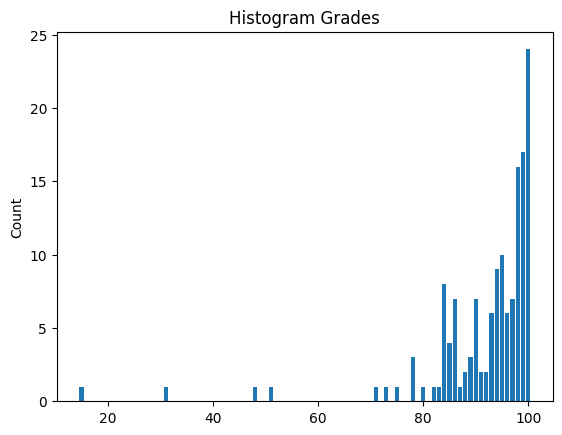

In [34]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [35]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [36]:
# TF-IDF Approach

df = pd.merge(df, question_mapping_scores_tf_idf, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.304749,0.429209,0.445114,0.345680,0.407512,0.373424,0.197718,0.167528,0.135585
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.202965,0.363552,0.458672,0.404428,0.365454,0.340874,0.390960,0.316486,0.195958
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.164778,0.124030,0.272360,0.264555,0.367945,0.160102,0.204623,0.326275,0.209939
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.176261,0.113966,0.286171,0.486557,0.283867,0.312700,0.344656,0.286588,0.328314
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.297222,0.459364,0.514944,0.395843,0.377086,0.345690,0.343304,0.276648,0.218038


In [37]:
#  BoW Approach

df = pd.merge(df, question_mapping_scores_BoW, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0_x,...,Q_8_x,Q_0_y,Q_1_y,Q_2_y,Q_3_y,Q_4_y,Q_5_y,Q_6_y,Q_7_y,Q_8_y
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.304749,...,0.135585,0.619439,0.564218,0.705126,0.552229,0.659997,0.589307,0.502981,0.554046,0.414642
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.202965,...,0.195958,0.594736,0.487180,0.736255,0.605228,0.591974,0.588859,0.630582,0.661897,0.520978
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.164778,...,0.209939,0.536862,0.390286,0.543560,0.488405,0.536550,0.409906,0.462096,0.588057,0.489059
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.176261,...,0.328314,0.581038,0.442235,0.639362,0.711006,0.542010,0.528981,0.623511,0.628681,0.585251
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.297222,...,0.218038,0.623454,0.507757,0.735626,0.555692,0.649769,0.597020,0.582538,0.617163,0.479929


In [38]:
# Word2Vec Approach
# Care that question mapping scores of w2v is used since df is created with w2v in this cell.

df = pd.merge(df, question_mapping_scores_w2v, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0_x,...,Q_8_y,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.304749,...,0.414642,0.569898,0.559358,0.498455,0.596269,0.529698,0.569420,0.531863,0.500704,0.348046
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.202965,...,0.520978,0.554213,0.553771,0.607182,0.533035,0.520501,0.528132,0.625979,0.501554,0.350057
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.164778,...,0.489059,0.622121,0.590521,0.634738,0.603706,0.602858,0.614092,0.645924,0.567128,0.538799
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.176261,...,0.585251,0.567102,0.555681,0.522284,0.543931,0.540727,0.547088,0.533458,0.460165,0.409453
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.297222,...,0.479929,0.618506,0.633889,0.636678,0.626896,0.604195,0.642896,0.659561,0.593568,0.516572


#### Merging scores with features

In [39]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0_x,...,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.304749,...,0.569898,0.559358,0.498455,0.596269,0.529698,0.569420,0.531863,0.500704,0.348046,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.202965,...,0.554213,0.553771,0.607182,0.533035,0.520501,0.528132,0.625979,0.501554,0.350057,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.164778,...,0.622121,0.590521,0.634738,0.603706,0.602858,0.614092,0.645924,0.567128,0.538799,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.176261,...,0.567102,0.555681,0.522284,0.543931,0.540727,0.547088,0.533458,0.460165,0.409453,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.297222,...,0.618506,0.633889,0.636678,0.626896,0.604195,0.642896,0.659561,0.593568,0.516572,100.0


In [40]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 35) (122,)


#### Train/Test split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing 

In [42]:
regressor = DecisionTreeRegressor(random_state=0,criterion = 'squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [43]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 126.39409722222263
Node 2 has MSE 278.99609375
Node 3 has MSE 118.06243496358093
Node 4 has MSE 148.79338842975267
Node 5 has MSE 61.649999999999636
Node 6 has MSE 32.33333333333303
Node 7 has MSE 9.0
Node 8 has MSE 0.0
Node 9 has MSE 0.0
Node 10 has MSE 7.25
Node 11 has MSE 1.0
Node 12 has MSE 0.0
Node 13 has MSE 0.0
Node 14 has MSE 1.0
Node 15 has MSE 0.0
Node 16 has MSE 0.0
Node 17 has MSE 29.6875
Node 18 has MSE 5.555555555555657
Node 19 has MSE 0.0
Node 20 has MSE 0.0
Node 21 has MSE 0.0
Node 22 has MSE 0.0
Node 23 has MSE 55.88750000000073
Node 24 has MSE 32.620498614958706
Node 25 has MSE 8.888888888888687
Node 26 has MSE 0.0
Node 27 has MSE 2.4375
Node 28 has MSE 0.6666666666660603
Node 29 has MSE 0.25
Node 30 has MSE 0.0
Node 31 has MSE 0.0
Node 32 has MSE 0.0
Node 33 has MSE 1.0
Node 34 has MSE 0.0
Node 35 has MSE 0.0
Node 36 has MSE 33.76000000000022
Node 37 has MSE 15.632653061225938
Node 38 has MSE 7.25
Node 39 has MSE 0.666

In [44]:
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

In [45]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 1.5481377909484255
MSE TEST: 92.92977218297483
R2 Train: 0.9905266518851618
R2 TEST: 0.1722328818179849
